In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Comparing LSA, LDA, and NNMF

Now that you've been introduced to the logic behind these three topic extraction methods, we're going to try them out on the *Emma* corpus.  We'll be looking at interpretability, speed, and consistency across methods.  The goal is to identify common themes in *Emma* on a per-paragraph basis.  We won't be using pLSA as sklearn does not support it.

To do this, we will:

1. Parse and process the data into a tf-idf matrix.
2. Fit LSA, LDA, and NNMF models with 5 topics each.
4. Extract the words that best describe each topic.
5. Examine the topic relationships for the words 'marriage', 'love', and 'Emma.'

## Generating the tfidf matrix

In [2]:
# Processing the data.

from nltk.corpus import gutenberg
import re
from sklearn.feature_extraction.text import TfidfVectorizer


#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=5

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10


In addition to creating the tfidf matrix, there are two convenience functions that will help keep the code tidy when comparing models.  The first provides a list of the words that are paired with each topic.  The second gives us the best words for each topic so we can compare across methods.

## Fitting the three topic extraction models

In [3]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
emma_paras_lsa = lsa.fit_transform(emma_paras_tfidf)

components_lsa = word_topic(emma_paras_tfidf, emma_paras_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                


In [4]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_topics=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

emma_paras_lda = lda.fit_transform(emma_paras_tfidf) 

components_lda = word_topic(emma_paras_tfidf, emma_paras_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)


C:\Users\Loren\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\Loren\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [5]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
emma_paras_nmf = nmf.fit_transform(emma_paras_tfidf) 

components_nmf = word_topic(emma_paras_tfidf, emma_paras_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

We are mostly using the default settings for each method, but explicitly printing them so it is clear what is going on and how each model can be modified.  sklearn has such nice parallel structure for its various topic extraction methods that we could probably have abstracted the code even further.

# Inspecting the topics

For each topic, we list the ten most-relevant words according to each method:

In [6]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])
    

Topic 0:
               LSA              LDA             NNMF
0          oh 97.6         mr 51.75         oh 30.12
0         yes 4.76       emma 49.65         yes 0.52
0       thank 1.63       said 40.12       sorry 0.16
0  difference 1.56        mrs 35.04  difference 0.15
0        just 1.43       miss 30.12        just 0.12
0     harriet 1.29    harriet 27.06        papa 0.12
0       sorry 1.28     weston 25.63        week 0.11
0       short 1.17  knightley 24.39       short 0.11
0        papa 1.15      elton 23.29    recollect 0.1
0   recollect 1.01        did 20.65      letter 0.09
Topic 1:
               LSA           LDA            NNMF
1       emma 58.56      oh 56.59         mr 7.29
1         mr 58.02      ah 18.06        mrs 4.26
1       said 50.15     emma 7.16      elton 3.41
1        mrs 47.15     said 4.97  knightley 3.24
1       miss 37.91       mr 4.88     weston 3.15
1    harriet 33.83  chapter 4.14       miss 2.99
1     weston 32.27  harriet 3.68  woodhouse 2.09
1      

A number of things are clear.  First, some topics are shared, though the order of topics varies- the 'oh' topic is first for LSA and NNMF, but second for LDA.  And second, the content of some of the topics varies considerably across methods.  This is a clear argument for using multiple methods when exploring topics.

# Sparsity

Now let's examine sparsity by looking at the distributions of loadings for the words 'marriage', 'love', 'emma', and 'oh' across the methods:

0    4.691144e-02
1    3.096637e+00
2   -8.628550e-02
3    8.668115e-03
4    7.423949e-01
0    1.992386e+00
1    1.957083e-01
2    2.533039e-01
3    5.528729e-01
4    5.296164e-01
0    1.763702e-04
1    1.057906e-01
2    9.844702e-05
3    4.073648e-15
4    3.514428e-02
Name: marriage, dtype: float64
0    7.100199e-02
1    8.783243e+00
2   -1.789705e-01
3   -3.766844e-02
4   -2.832976e+00
0    6.616265e+00
1    6.468237e-01
2    1.133355e+00
3    9.640096e-01
4    1.002675e+00
0    5.304526e-04
1    2.516977e-01
2    2.047230e-03
3    1.206335e-13
4    4.286042e-01
Name: love, dtype: float64
0    5.856342e-01
1    5.855569e+01
2   -1.370918e+00
3    1.566077e-01
4   -4.071772e+01
0    4.964651e+01
1    7.164297e+00
2    7.104396e+00
3    5.719460e+00
4    7.496515e+00
0    1.816604e-02
1    1.466726e+00
2    1.317691e-02
3    5.640619e-13
4    9.273954e+00
Name: emma, dtype: float64
0    9.759904e+01
1    5.232720e-01
2   -8.956893e-03
3    3.838096e-03
4   -3.462989e-01
0    1.154813e+

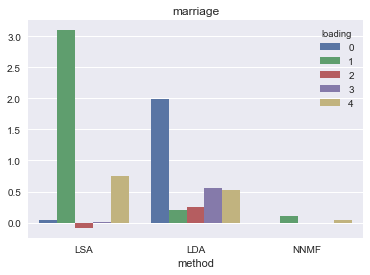

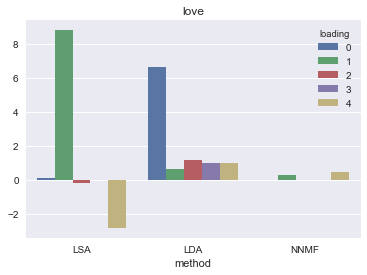

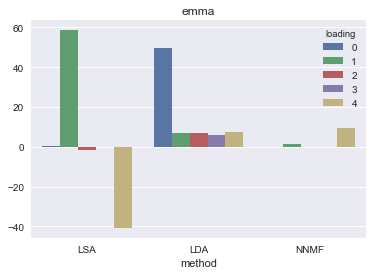

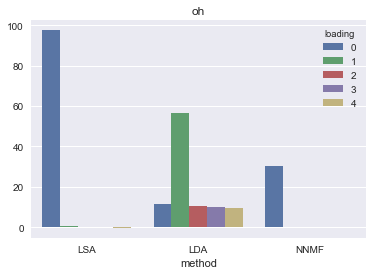

In [10]:
# The words to look at.
targetwords=['marriage','love','emma','oh']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    print(loadings)
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()


In [8]:
wordloadings

,marriage,love,emma,oh,method,loading
0,4.691144e-02,7.100199e-02,5.856342e-01,9.759904e+01,LSA,0
1,3.096637e+00,8.783243e+00,5.855569e+01,5.232720e-01,LSA,1
2,-8.628550e-02,-1.789705e-01,-1.370918e+00,-8.956893e-03,LSA,2
3,8.668115e-03,-3.766844e-02,1.566077e-01,3.838096e-03,LSA,3
4,7.423949e-01,-2.832976e+00,-4.071772e+01,-3.462989e-01,LSA,4
0,1.992386e+00,6.616265e+00,4.964651e+01,1.154813e+01,LDA,0
1,1.957083e-01,6.468237e-01,7.164297e+00,5.658545e+01,LDA,1
2,2.533039e-01,1.133355e+00,7.104396e+00,1.033519e+01,LDA,2
3,5.528729e-01,9.640096e-01,5.719460e+00,9.788951e+00,LDA,3
4,5.296164e-01,1.002675e+00,7.496515e+00,9.731062e+00,LDA,4


In [11]:
components_lsa.loc['emma']

0     0.585634
1    58.555685
2    -1.370918
3     0.156608
4   -40.717718
Name: emma, dtype: float64

LSA is the method most likely to have high loadings on more than one topic for the same word.  LDA tends to have one high loading and some lower loadings.  Loadings for NNMF are lower all around, and the most sparse, with some of the topics having loadings of zero on each word.

# Challenge: Topic extraction on new data

Take the well-known [20 newsgroups](http://qwone.com/~jason/20Newsgroups/) dataset and use each of the methods on it.  Your goal is to determine which method, if any, best reproduces the topics represented by the newsgroups.  Write up a report where you evaluate each method in light of the 'ground truth'- the known source of each newsgroup post.  Which works best, and why do you think this is the case?



In [49]:
from sklearn.datasets import fetch_20newsgroups
news = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), subset='all')


In [50]:
news.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [51]:
news.data[0]

"\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n"

In [52]:
# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
news_tfidf=vectorizer.fit_transform(news.data)

In [53]:
# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=20

In [54]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
news_lsa = lsa.fit_transform(news_tfidf)

components_lsa = word_topic(news_tfidf, news_lsa, terms)

# Number of words to look at for each topic.
n_top_words = 10

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                


In [55]:
print(news_lsa.shape)
print(news.target.shape)


(18846, 20)
(18846,)


In [56]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_topics=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          
         )

news_lda = lda.fit_transform(news_tfidf) 

components_lda = word_topic(news_tfidf, news_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

C:\Users\Loren\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
C:\Users\Loren\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [57]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
news_nmf = nmf.fit_transform(news_tfidf) 

components_nmf = word_topic(news_tfidf, news_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

In [58]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
             LSA          LDA         NNMF
0     like 146.5    know 1.98     don 4.55
0      don 145.9    just 1.87    just 4.37
0    just 144.54    like 1.85    like 3.56
0    know 132.62     don 1.77   think 3.52
0  people 128.54     does 1.7    know 2.59
0   think 122.88  thanks 1.69  people 2.46
0    does 102.35   think 1.52      ve 2.22
0    time 101.13  people 1.45    good 2.11
0     good 98.73     use 1.32    time 2.03
0      use 98.67    good 1.29     say 1.87
Topic 1:
              LSA          LDA              NNMF
1   windows 53.64    know 1.94       window 3.71
1    thanks 49.18    just 1.86      problem 1.75
1     drive 32.34    like 1.82          use 1.64
1       card 32.3     don 1.76       server 1.44
1       dos 30.19    does 1.69  application 1.28
1  software 27.58  thanks 1.62        using 1.28
1        pc 27.56   think 1.51      program 1.21
1      file 27.26  people 1.42      windows 1.19
1       use 26.29     use 1.36        motif 1.11
1   program 25.22  

Comparing the topics based on the top words to the actual 'ground truth' topics reveals a few things. First, LDA produced almost the same list of top words for every topic except 1. LSA was able to identify some of the topics, but NNMF performed the best. Comparing the list of actual topics to the top words, you can see most of the topics have been identified by the model.
